# Linguagem, Bibliotecas e Pacotes

In [87]:
# Import libs

import numpy as np
import pandas as pd
import missingno as msno
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from keras import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler


# Leitura dos Dados

In [88]:
# Read NBA data from excel file

nba_data = pd.read_excel('nba_data.xlsx')

In [89]:
# Drop "Unnamed: 0" column

nba_data.drop(['Unnamed: 0'], axis=1, inplace=True)
nba_data.head()

,HOME_WL,GP_x,W_x,L_x,W_PCT_x,MIN_x,FGM_x,FGA_x,FG_PCT_x,FG3M_x,...,REB_RANK_y,AST_RANK_y,TOV_RANK_y,STL_RANK_y,BLK_RANK_y,BLKA_RANK_y,PF_RANK_y,PFD_RANK_y,PTS_RANK_y,PLUS_MINUS_RANK_y
0,W,1,1,0,1.000,48.0,42.0,92.0,0.457,11.0,...,12,15,14,2,6,2,25,8,8,7
1,W,2,1,1,0.500,48.0,43.0,81.0,0.531,13.0,...,10,17,24,21,2,7,7,27,18,9
2,W,3,2,1,0.667,49.7,42.0,86.3,0.486,11.0,...,8,9,9,14,28,30,10,7,17,27
3,L,4,3,1,0.750,49.3,42.5,86.0,0.494,10.8,...,9,7,16,26,3,21,23,17,11,25
4,W,5,3,2,0.600,49.0,41.6,86.0,0.484,15.2,...,24,14,23,21,5,7,19,23,20,11


# Análise Inicial

In [90]:
# Get nba_data dataframa shape

nba_data.shape

(6963, 105)

In [91]:
# Get nba_data dataframe columns

nba_data.columns

Index(['HOME_WL', 'GP_x', 'W_x', 'L_x', 'W_PCT_x', 'MIN_x', 'FGM_x', 'FGA_x',
       'FG_PCT_x', 'FG3M_x',
       ...
       'REB_RANK_y', 'AST_RANK_y', 'TOV_RANK_y', 'STL_RANK_y', 'BLK_RANK_y',
       'BLKA_RANK_y', 'PF_RANK_y', 'PFD_RANK_y', 'PTS_RANK_y',
       'PLUS_MINUS_RANK_y'],
      dtype='object', length=105)

In [92]:
# Get nba_data dataframe describe

nba_data.describe()

,GP_x,W_x,L_x,W_PCT_x,MIN_x,FGM_x,FGA_x,FG_PCT_x,FG3M_x,FG3A_x,...,REB_RANK_y,AST_RANK_y,TOV_RANK_y,STL_RANK_y,BLK_RANK_y,BLKA_RANK_y,PF_RANK_y,PFD_RANK_y,PTS_RANK_y,PLUS_MINUS_RANK_y
count,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,...,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000
mean,39.421657,19.688640,19.733017,0.498711,48.315712,40.513055,88.108358,0.459894,11.760606,33.007928,...,15.370243,15.345541,15.321844,15.419647,15.286514,15.244004,15.371248,15.439466,15.327876,15.286227
std,22.634354,13.039842,13.080083,0.173915,0.367160,2.042301,3.016847,0.019334,1.826029,4.643194,...,8.632790,8.664255,8.648501,8.662756,8.643116,8.639085,8.656732,8.616650,8.637555,8.633215
min,1.000000,0.000000,0.000000,0.000000,48.000000,25.000000,73.000000,0.298000,4.500000,16.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,20.000000,9.000000,9.000000,0.390000,48.100000,39.100000,86.100000,0.448000,10.600000,30.100000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,39.000000,18.000000,18.000000,0.500000,48.300000,40.500000,88.000000,0.461000,11.600000,32.800000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,16.000000,15.000000,15.000000
75%,59.000000,29.000000,29.000000,0.613000,48.400000,41.900000,90.000000,0.472000,12.800000,35.850000,...,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
max,81.000000,64.000000,64.000000,1.000000,58.000000,54.000000,117.000000,0.560000,23.000000,57.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [93]:
# Get classes

nba_data['HOME_WL'].value_counts()

HOME_WL
W    3936
L    3027
Name: count, dtype: int64

In [94]:
# Get nba_data dataframe info

nba_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6963 entries, 0 to 6962
Columns: 105 entries, HOME_WL to PLUS_MINUS_RANK_y
dtypes: float64(46), int64(58), object(1)
memory usage: 5.6+ MB


# Chegagem de valores nulos

<Axes: >

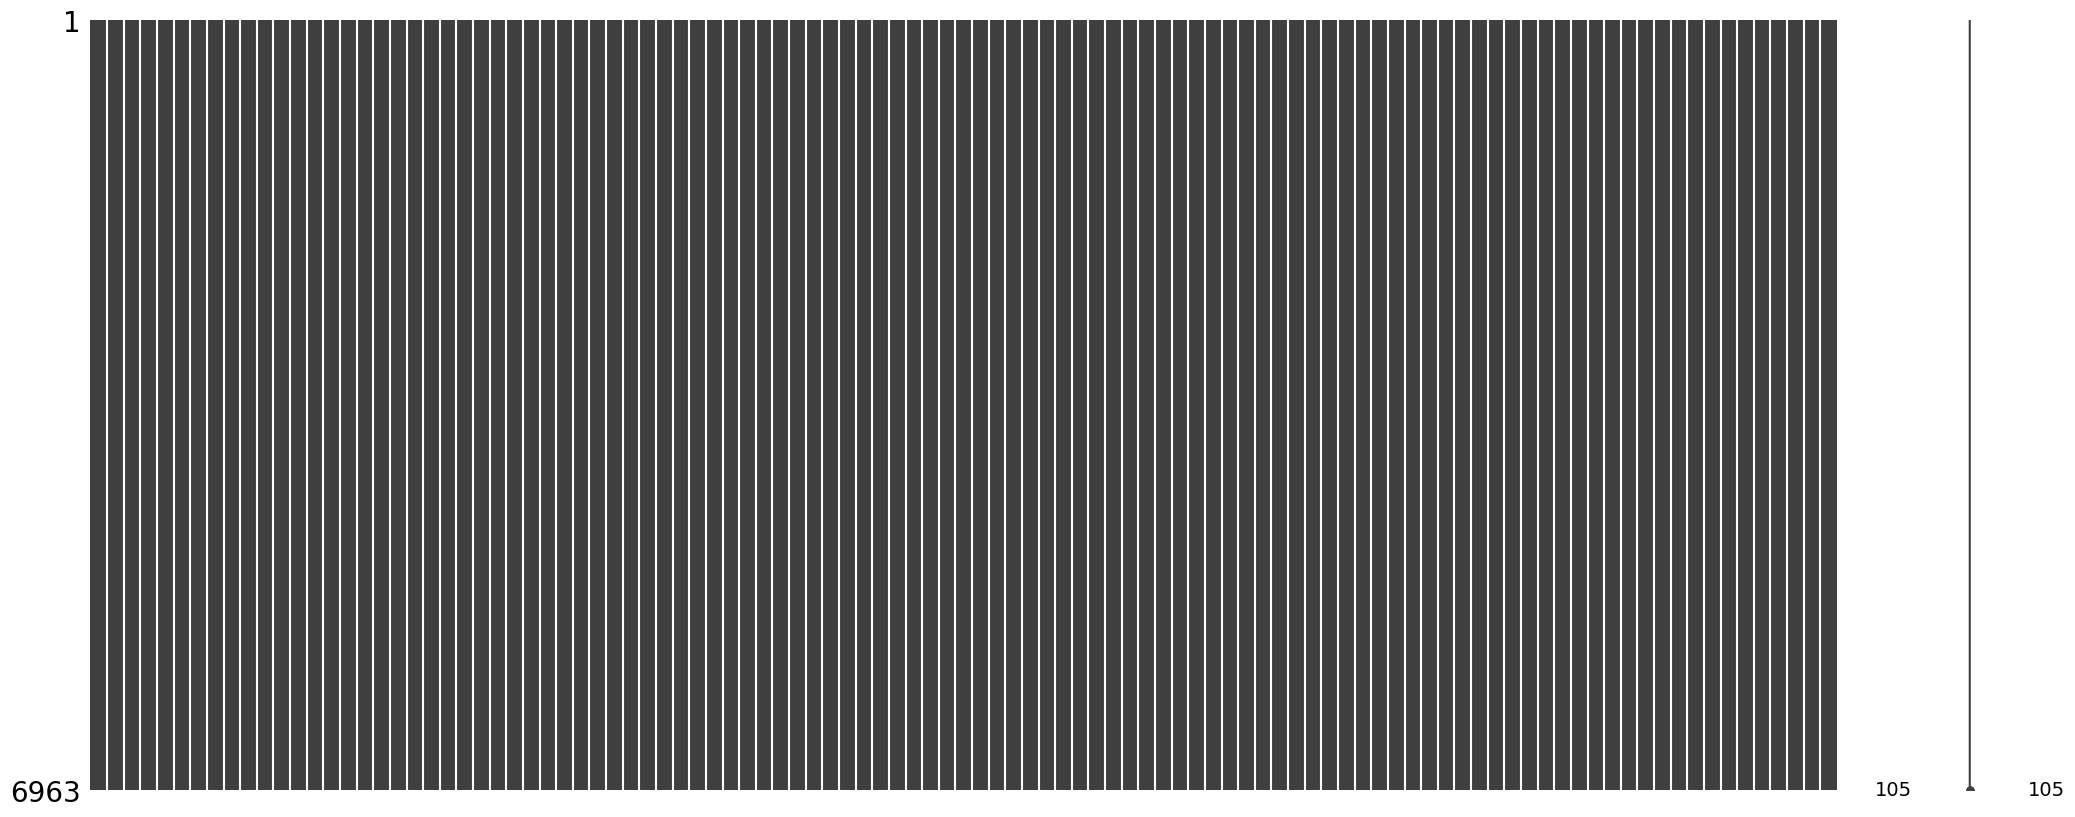

In [95]:
msno.matrix(nba_data)

# Relatório Pandas Profile

    Foi gerado o 'Pandas Profile Report' que oferece uma análise extensa do conjunto de dados que está sendo abordado.

In [10]:
# Generate and export as a .html file the Pandas Profile Report of the nba_shots dataframe

profile_data = ProfileReport(nba_data, title ='nba_data')
profile_data.to_file("nba_data_pandas_profile_report.html")

Summarize dataset:  95%|█████████▍| 106/112 [00:02<00:00, 37.38it/s, Calculate auto correlation]         


KeyboardInterrupt: 

In [ ]:
# Show Profile Report in this notebook

profile_data.to_notebook_iframe()

# Previsão de resultados utilizando Redes Neurais

In [96]:
# Turn categorical column HOME_WL into numerial

nba_data['HOME_WL'] = nba_data['HOME_WL'].apply(lambda x: 0 if x == 'W' else 1)
nba_data.head()

,HOME_WL,GP_x,W_x,L_x,W_PCT_x,MIN_x,FGM_x,FGA_x,FG_PCT_x,FG3M_x,...,REB_RANK_y,AST_RANK_y,TOV_RANK_y,STL_RANK_y,BLK_RANK_y,BLKA_RANK_y,PF_RANK_y,PFD_RANK_y,PTS_RANK_y,PLUS_MINUS_RANK_y
0,0,1,1,0,1.000,48.0,42.0,92.0,0.457,11.0,...,12,15,14,2,6,2,25,8,8,7
1,0,2,1,1,0.500,48.0,43.0,81.0,0.531,13.0,...,10,17,24,21,2,7,7,27,18,9
2,0,3,2,1,0.667,49.7,42.0,86.3,0.486,11.0,...,8,9,9,14,28,30,10,7,17,27
3,1,4,3,1,0.750,49.3,42.5,86.0,0.494,10.8,...,9,7,16,26,3,21,23,17,11,25
4,0,5,3,2,0.600,49.0,41.6,86.0,0.484,15.2,...,24,14,23,21,5,7,19,23,20,11


In [330]:
# Separate database in train and test

X = nba_data.loc[:, nba_data.columns != 'HOME_WL']
y = nba_data['HOME_WL']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= 0.3, 
                                                    random_state = 100, 
                                                    stratify = y,
                                                    )

In [331]:
# Check columns with variance equal to zero and drop them

zero_var_filter = VarianceThreshold()
X_train = zero_var_filter.fit_transform(X_train)
X_test = zero_var_filter.transform(X_test)
print('X_train e X_test possuíam', (zero_var_filter.variances_ == 0).sum(), 'atributo(s) com variância igual a zero')

print(zero_var_filter.variances_ == 0)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train e X_test possuíam 0 atributo(s) com variância igual a zero
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
X_train: (4874, 104)
X_test: (2089, 104)
y_train: (4874,)
y_test: (2089,)


In [332]:
# Normalize data

preprocessParams = preprocessing.StandardScaler().fit(X_train)
X_train_normalized = preprocessParams.transform(X_train)
X_test_normalized = preprocessParams.transform(X_test)

X_train_normalized

array([[-0.19390183, -0.51290067,  0.17945249, ..., -0.17228294,
        -0.60944706,  0.07584392],
       [-1.61094241, -1.43070805, -1.36273462, ...,  1.22296558,
         0.88705677,  1.1184542 ],
       [-1.21239975, -1.43070805, -0.66875042, ...,  0.06025848,
        -1.18502546, -1.19845753],
       ...,
       [ 0.95744365,  0.94029435,  0.71921797, ..., -1.21871934,
        -1.06990978,  1.00260862],
       [ 0.69174854,  1.47568199, -0.28320365, ...,  0.87415345,
         1.46263517,  0.53922627],
       [-1.38952982, -1.12477225, -1.28562526, ..., -1.21871934,
         0.19636269, -1.31430312]])

In [333]:
# Train Neural Network

NumberOfClasses = len(y_train.unique())
NumberOfClasses

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
print(y_train)

[0 0 0 ... 1 0 1]


In [334]:
# Neural Network

RN = Sequential()
RN.add(Dense(5,input_shape = X_train_normalized.shape[1:],activation = 'sigmoid'))
RN.add(Dense(5,activation = 'sigmoid'))
RN.add(Dense(5,activation = 'sigmoid'))
RN.add(Dense(NumberOfClasses,activation = 'sigmoid'))
RN.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 5)                 525       
                                                                 
 dense_100 (Dense)           (None, 5)                 30        
                                                                 
 dense_101 (Dense)           (None, 2)                 12        
                                                                 
Total params: 567 (2.21 KB)
Trainable params: 567 (2.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [335]:
# Training

RN.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy']) 
history = RN.fit(X_train_normalized, to_categorical(y_train), epochs = 350, 
                    batch_size=32, validation_split=0.3)

Epoch 1/350
107/107 [==============================] - 1s 3ms/step - loss: 0.6934 - accuracy: 0.5778 - val_loss: 0.6901 - val_accuracy: 0.5543
Epoch 2/350
107/107 [==============================] - 0s 2ms/step - loss: 0.6844 - accuracy: 0.5708 - val_loss: 0.6842 - val_accuracy: 0.5543
Epoch 3/350
107/107 [==============================] - 0s 1ms/step - loss: 0.6796 - accuracy: 0.5702 - val_loss: 0.6813 - val_accuracy: 0.5537
Epoch 4/350
107/107 [==============================] - 0s 2ms/step - loss: 0.6771 - accuracy: 0.5702 - val_loss: 0.6796 - val_accuracy: 0.5537
Epoch 5/350
107/107 [==============================] - 0s 1ms/step - loss: 0.6756 - accuracy: 0.5702 - val_loss: 0.6787 - val_accuracy: 0.5537
Epoch 6/350
107/107 [==============================] - 0s 1ms/step - loss: 0.6746 - accuracy: 0.5702 - val_loss: 0.6780 - val_accuracy: 0.5537
Epoch 7/350
107/107 [==============================] - 0s 2ms/step - loss: 0.6740 - accuracy: 0.5702 - val_loss: 0.6774 - val_accuracy: 0.5537

In [336]:
# Evaluation

score = RN.evaluate(X_test_normalized, to_categorical(y_test), verbose = 0)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

Test loss score: 0.642283022403717
Test accuracy: 0.6519865989685059


In [337]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


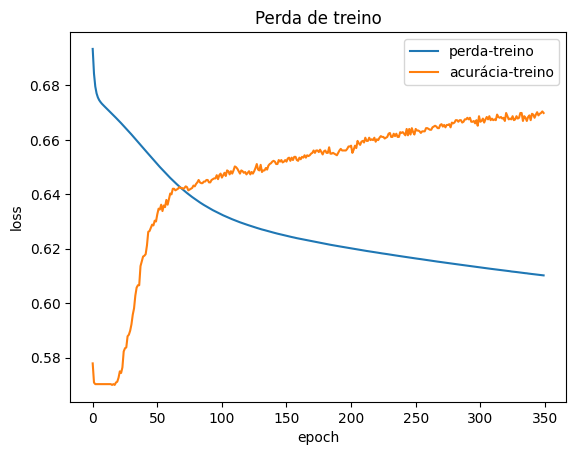

In [338]:
# Training chart: Training and validation per loss and epochs

plt.plot(history.history['loss'], label='perda-treino')
#plt.plot(history.history['val_loss'], label='validação')
plt.plot(history.history['accuracy'], label='acurácia-treino')
plt.title('Perda de treino')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

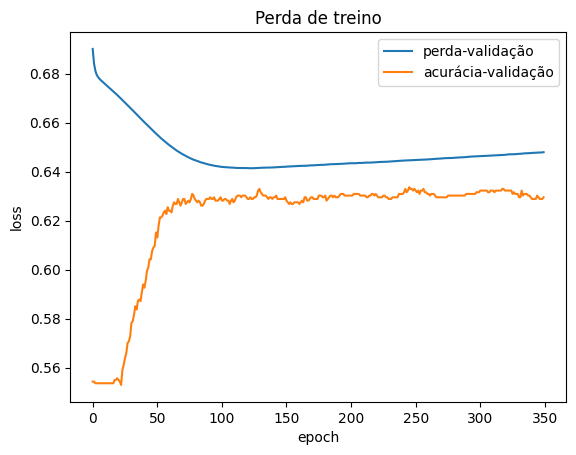

In [339]:
# Training chart: Validation and validation per loss and epochs

plt.plot(history.history['val_loss'], label='perda-validação')
#plt.plot(history.history['val_loss'], label='validação')
plt.plot(history.history['val_accuracy'], label='acurácia-validação')
plt.title('Perda de treino')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()